# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase3_all_to_20220311.csv')

## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
HFA_poly3 = Polygon([(7.6, 13.3), (7.6, 5.8), (14.2, 5.8), (14.2, 13.3)])

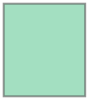

In [ ]:
HFA_poly3

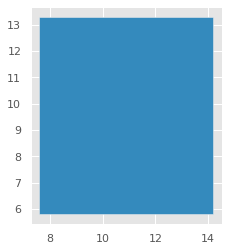

In [ ]:
 p = gpd.GeoSeries(HFA_poly3)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
HFA_poly3_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(HFA_poly3))

In [ ]:
HFA_poly3_gdf

,geometry
0,"POLYGON ((7.60000 13.30000, 7.60000 5.80000, 1..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
HFA_join = gpd.sjoin(gdf, HFA_poly3_gdf, how = 'inner')
HFA_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
14,G2341,"8.736,10.687",07/03/2022 10:23,07/03/2022 10:23,8.736,10.687,POINT (8.73600 10.68700),0
15,G2341,"8.038,9.935",07/03/2022 10:23,07/03/2022 10:25,8.038,9.935,POINT (8.03800 9.93500),0
17,G2341,"7.891,9.587",07/03/2022 10:27,07/03/2022 10:27,7.891,9.587,POINT (7.89100 9.58700),0
19,G2341,"7.83,9.498",07/03/2022 10:27,07/03/2022 10:29,7.83,9.498,POINT (7.83000 9.49800),0
20,G2341,"7.751,8.345",07/03/2022 10:29,07/03/2022 10:29,7.751,8.345,POINT (7.75100 8.34500),0
...,...,...,...,...,...,...,...,...
16211,R2409,"10.632,7.075",09/03/2022 15:33,09/03/2022 15:34,10.632,7.075,POINT (10.63200 7.07500),0
16212,R2409,"12.032,7.075",09/03/2022 15:34,09/03/2022 15:38,12.032,7.075,POINT (12.03200 7.07500),0
16274,R2409,"13.615,5.842",09/03/2022 16:15,09/03/2022 16:15,13.615,5.842,POINT (13.61500 5.84200),0
16276,R2409,"9.683,5.987",09/03/2022 16:15,09/03/2022 16:15,9.683,5.987,POINT (9.68300 5.98700),0


## More data cleaning

In [ ]:
HFA_join['newfrom'] = lookup(HFA_join['from'], format='%d/%m/%Y %H:%M')
HFA_join['newto'] = lookup(HFA_join['to'], format='%d/%m/%Y %H:%M')

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
dfgrouped = HFA_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:40:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:40:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          148
mean     0 days 00:29:00.405405405
std      0 days 00:23:59.055755410
min                0 days 00:00:00
25%                0 days 00:10:45
50%                0 days 00:21:30
75%                0 days 00:46:00
max                0 days 01:40:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:26:35.094339622
morning     0 days 00:30:21.473684210
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:35:45.454545454
Tuesday,0 days 00:30:52.941176470
Wednesday,0 days 00:28:19.200000
Thursday,0 days 00:21:08.275862068
Friday,0 days 00:27:28.888888888
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
33
Tuesday
34
Wednesday
25
Thursday
29
Friday
27
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday,morning,10
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday,morning,10
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday,morning,10
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday,morning,10
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday,morning,10
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday,morning,10
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday,morning,11
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday,morning,11
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday,morning,11


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:33:40.540540540
11   0 days 00:28:06.666666666
12             0 days 00:38:10
13   0 days 00:22:09.473684210
14   0 days 00:25:55.714285714
15   0 days 00:30:54.545454545
16             0 days 00:01:00
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
37
Eleven
27
Twelve
12
One
19
Two
28
Three
22
Four
3


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:34:12.692307692
R   0 days 00:16:42.272727272
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
104
Medical Retinal
44


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday,morning,10,G,49.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday,morning,10,G,28.0000
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday,morning,10,G,10.0000
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday,morning,10,G,29.0000
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10,G,84.0000
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday,morning,11,G,35.0000
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday,morning,11,G,26.0000


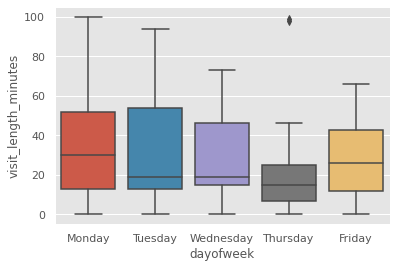

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

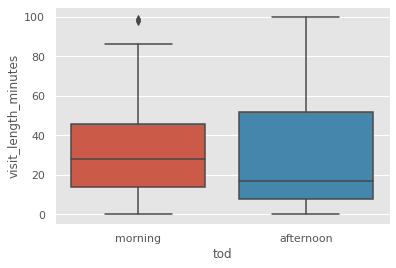

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

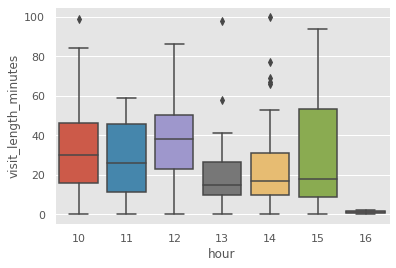

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

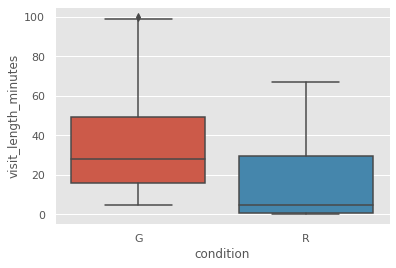

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 32
newfrom                 32
newto                   32
visit_length            32
start_day               32
end_day                 32
sameday                 32
dayofweek               32
tod                     32
hour                    32
condition               32
visit_length_minutes    32
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday,morning,10,G,49.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday,morning,10,G,28.0000
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday,morning,10,G,10.0000
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday,morning,10,G,29.0000
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10,G,84.0000
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday,morning,11,G,35.0000
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday,morning,11,G,26.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

29.006756756756758
31.335766423357665


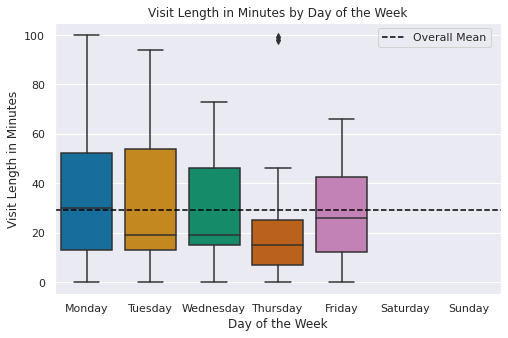

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

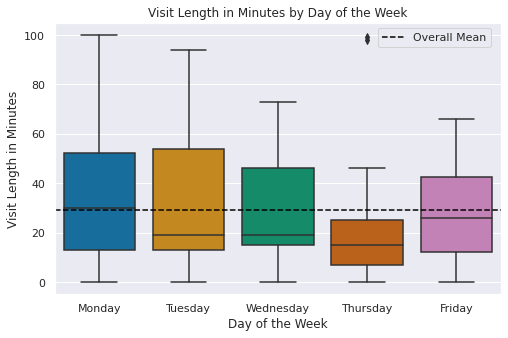

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

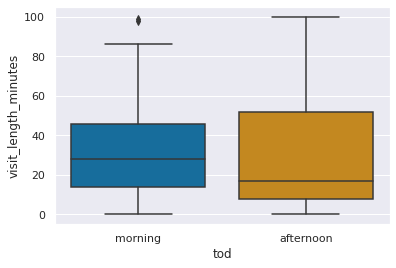

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

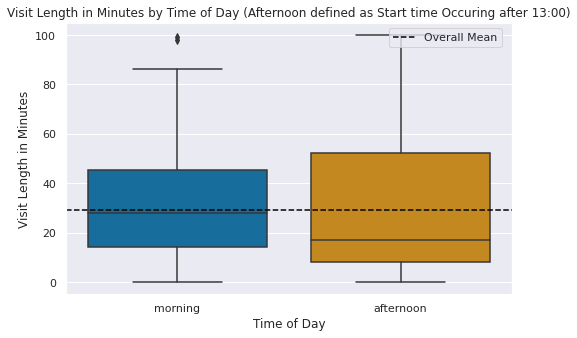

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

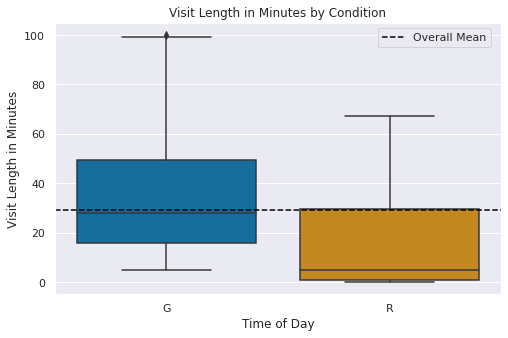

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

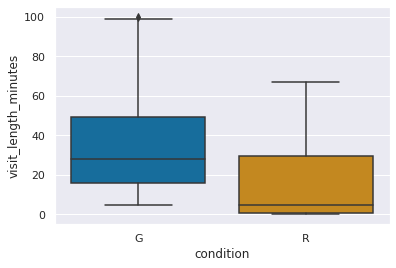

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

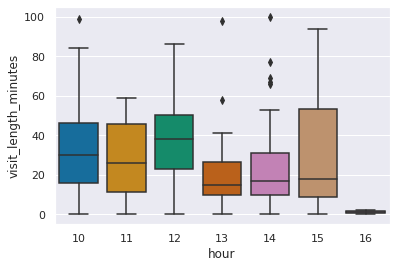

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

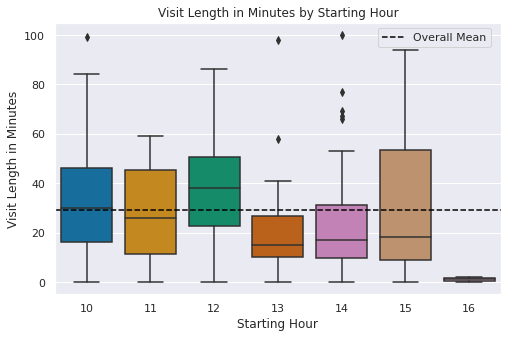

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   148.0000
mean                                     29.0068
std                                      23.9843
min                                       0.0000
25%                                      10.7500
50%                                      21.5000
75%                                      46.0000
max                                     100.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   148.0000
mean                                     29.0068
std                                      23.9843
min                                       0.0000
25%                                      10.7500
50%                                      21.5000
75%                                      46.0000
max                                     100.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

21.5

In [ ]:
df_outliers['visit_length'].describe()

count                          148
mean     0 days 00:29:00.405405405
std      0 days 00:23:59.055755410
min                0 days 00:00:00
25%                0 days 00:10:45
50%                0 days 00:21:30
75%                0 days 00:46:00
max                0 days 01:40:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          148
mean     0 days 00:29:00.405405405
std      0 days 00:23:59.055755410
min                0 days 00:00:00
25%                0 days 00:10:45
50%                0 days 00:21:30
75%                0 days 00:46:00
max                0 days 01:40:00
Name: visit_length, dtype: object

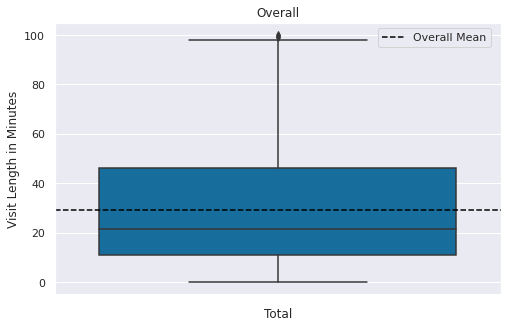

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
37
Eleven
27
Twelve
12
One
19
Two
28
Three
22
Four
3


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
33
Tuesday Outlier
34
Wednesday Outlier
25
Thursday Outlier
29
Friday Outlier
27
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       35.7576
Tuesday                                      30.8824
Wednesday                                    28.3200
Thursday                                     21.1379
Friday                                       27.4815
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
104
R
44


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    34.2115
R                                    16.7045
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
95
afternoon
53


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    26.5849
morning                                      30.3579
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
37
Eleven
27
Twelve
12
One
19
Two
28
Three
22
Four
3


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    33.6757
11                                    28.1111
12                                    38.1667
13                                    22.1579
14                                    25.9286
15                                    30.9091
16                                     1.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 32
newfrom                 32
newto                   32
visit_length            32
start_day               32
end_day                 32
sameday                 32
dayofweek               32
tod                     32
hour                    32
condition               32
visit_length_minutes    32
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 11
newfrom                 11
newto                   11
visit_length            11
start_day               11
end_day                 11
sameday                 11
dayofweek               11
tod                     11
hour                    11
condition               11
visit_length_minutes    11
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 137
newfrom                 137
newto                   137
visit_length            137
start_day               137
end_day                 137
sameday                 137
dayofweek               137
tod                     137
hour                    137
condition               137
visit_length_minutes    137
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
106,R1540,2022-03-07 11:59:00,2022-03-07 11:59:00,0 days,7,7,equal,Monday,morning,11,R,0.0000
111,R1550,2022-03-07 14:38:00,2022-03-07 14:38:00,0 days,7,7,equal,Monday,afternoon,14,R,0.0000
119,R1565,2022-03-08 14:45:00,2022-03-08 14:45:00,0 days,8,8,equal,Tuesday,afternoon,14,R,0.0000
120,R1567,2022-03-08 15:19:00,2022-03-08 15:19:00,0 days,8,8,equal,Tuesday,afternoon,15,R,0.0000
127,R1580,2022-03-09 13:47:00,2022-03-09 13:47:00,0 days,9,9,equal,Wednesday,morning,13,R,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
106,R1540,2022-03-07 11:59:00,2022-03-07 11:59:00,0 days,7,7,equal,Monday,morning,11,R,0.0000
111,R1550,2022-03-07 14:38:00,2022-03-07 14:38:00,0 days,7,7,equal,Monday,afternoon,14,R,0.0000
119,R1565,2022-03-08 14:45:00,2022-03-08 14:45:00,0 days,8,8,equal,Tuesday,afternoon,14,R,0.0000
120,R1567,2022-03-08 15:19:00,2022-03-08 15:19:00,0 days,8,8,equal,Tuesday,afternoon,15,R,0.0000
127,R1580,2022-03-09 13:47:00,2022-03-09 13:47:00,0 days,9,9,equal,Wednesday,morning,13,R,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
18,G2359,2022-03-07 14:07:00,2022-03-07 15:47:00,0 days 01:40:00,7,7,equal,Monday,afternoon,14,G,100.0000
67,G2411,2022-03-10 10:26:00,2022-03-10 12:05:00,0 days 01:39:00,10,10,equal,Thursday,morning,10,G,99.0000
78,G2423,2022-03-10 13:59:00,2022-03-10 15:37:00,0 days 01:38:00,10,10,equal,Thursday,morning,13,G,98.0000
46,G2388,2022-03-08 15:12:00,2022-03-08 16:46:00,0 days 01:34:00,8,8,equal,Tuesday,afternoon,15,G,94.0000
13,G2354,2022-03-07 12:30:00,2022-03-07 13:56:00,0 days 01:26:00,7,7,equal,Monday,morning,12,G,86.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
18,G2359,2022-03-07 14:07:00,2022-03-07 15:47:00,0 days 01:40:00,7,7,equal,Monday,afternoon,14,G,100.0000
67,G2411,2022-03-10 10:26:00,2022-03-10 12:05:00,0 days 01:39:00,10,10,equal,Thursday,morning,10,G,99.0000
78,G2423,2022-03-10 13:59:00,2022-03-10 15:37:00,0 days 01:38:00,10,10,equal,Thursday,morning,13,G,98.0000
46,G2388,2022-03-08 15:12:00,2022-03-08 16:46:00,0 days 01:34:00,8,8,equal,Tuesday,afternoon,15,G,94.0000
13,G2354,2022-03-07 12:30:00,2022-03-07 13:56:00,0 days 01:26:00,7,7,equal,Monday,morning,12,G,86.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
18,G2359,2022-03-07 14:07:00,2022-03-07 15:47:00,0 days 01:40:00,7,7,equal,Monday,afternoon,14,G,100.0000
67,G2411,2022-03-10 10:26:00,2022-03-10 12:05:00,0 days 01:39:00,10,10,equal,Thursday,morning,10,G,99.0000
78,G2423,2022-03-10 13:59:00,2022-03-10 15:37:00,0 days 01:38:00,10,10,equal,Thursday,morning,13,G,98.0000
46,G2388,2022-03-08 15:12:00,2022-03-08 16:46:00,0 days 01:34:00,8,8,equal,Tuesday,afternoon,15,G,94.0000
13,G2354,2022-03-07 12:30:00,2022-03-07 13:56:00,0 days 01:26:00,7,7,equal,Monday,morning,12,G,86.0000
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10,G,84.0000
41,G2383,2022-03-08 14:29:00,2022-03-08 15:46:00,0 days 01:17:00,8,8,equal,Tuesday,afternoon,14,G,77.0000
52,G2394,2022-03-09 10:45:00,2022-03-09 11:58:00,0 days 01:13:00,9,9,equal,Wednesday,morning,10,G,73.0000
19,G2360,2022-03-07 14:36:00,2022-03-07 15:45:00,0 days 01:09:00,7,7,equal,Monday,afternoon,14,G,69.0000
110,R1549,2022-03-07 14:25:00,2022-03-07 15:32:00,0 days 01:07:00,7,7,equal,Monday,afternoon,14,R,67.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
18,G2359,2022-03-07 14:07:00,2022-03-07 15:47:00,0 days 01:40:00,7,7,equal,Monday,afternoon,14,G,100.0000
67,G2411,2022-03-10 10:26:00,2022-03-10 12:05:00,0 days 01:39:00,10,10,equal,Thursday,morning,10,G,99.0000
78,G2423,2022-03-10 13:59:00,2022-03-10 15:37:00,0 days 01:38:00,10,10,equal,Thursday,morning,13,G,98.0000
46,G2388,2022-03-08 15:12:00,2022-03-08 16:46:00,0 days 01:34:00,8,8,equal,Tuesday,afternoon,15,G,94.0000
13,G2354,2022-03-07 12:30:00,2022-03-07 13:56:00,0 days 01:26:00,7,7,equal,Monday,morning,12,G,86.0000
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10,G,84.0000
41,G2383,2022-03-08 14:29:00,2022-03-08 15:46:00,0 days 01:17:00,8,8,equal,Tuesday,afternoon,14,G,77.0000
52,G2394,2022-03-09 10:45:00,2022-03-09 11:58:00,0 days 01:13:00,9,9,equal,Wednesday,morning,10,G,73.0000
19,G2360,2022-03-07 14:36:00,2022-03-07 15:45:00,0 days 01:09:00,7,7,equal,Monday,afternoon,14,G,69.0000
110,R1549,2022-03-07 14:25:00,2022-03-07 15:32:00,0 days 01:07:00,7,7,equal,Monday,afternoon,14,R,67.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 10:23:00,2022-03-07 10:53:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
1,G2342,2022-03-07 10:36:00,2022-03-07 11:25:00,0 days 00:49:00,7,7,equal,Monday,morning,10,G,49.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 11:11:00,0 days 00:28:00,7,7,equal,Monday,morning,10,G,28.0000
3,G2344,2022-03-07 10:37:00,2022-03-07 11:07:00,0 days 00:30:00,7,7,equal,Monday,morning,10,G,30.0000
4,G2345,2022-03-07 10:45:00,2022-03-07 10:55:00,0 days 00:10:00,7,7,equal,Monday,morning,10,G,10.0000
5,G2346,2022-03-07 10:53:00,2022-03-07 11:22:00,0 days 00:29:00,7,7,equal,Monday,morning,10,G,29.0000
6,G2347,2022-03-07 10:59:00,2022-03-07 12:23:00,0 days 01:24:00,7,7,equal,Monday,morning,10,G,84.0000
7,G2348,2022-03-07 11:23:00,2022-03-07 11:29:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:22:00,2022-03-07 11:57:00,0 days 00:35:00,7,7,equal,Monday,morning,11,G,35.0000
9,G2350,2022-03-07 11:18:00,2022-03-07 11:44:00,0 days 00:26:00,7,7,equal,Monday,morning,11,G,26.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'ORA_AF'
HFAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
HFAdf.to_csv('ORA_AFdf_phase3.csv', index=False)